In [1]:
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')

# 데이터 확인

In [2]:
image_dir = 'poster/daum/'
genre_dir = 'poster/daum.txt'

genres_dict = pickle.load(open(genre_dir, 'rb'))
sample_img_dir = image_dir+'242.jpg'
sample_genre = genres_dict[int(os.listdir(image_dir)[0].split('.')[0])]
sample_img_dir,sample_genre

('poster/daum/242.jpg', ['애니메이션'])

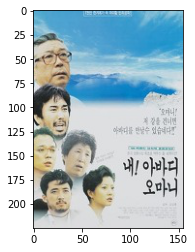

['애니메이션']
(225, 155, 3)


In [3]:
_ = plt.imread(sample_img_dir)
plt.imshow(_)
plt.show()
print(sample_genre)
print(_.shape)

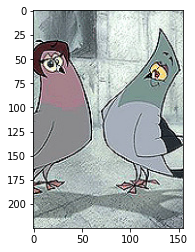

['애니메이션']



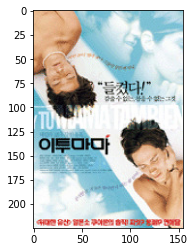

['코미디', '로맨스', '멜로', '드라마']



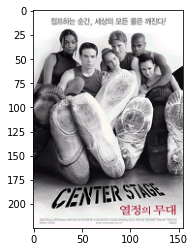

['드라마']



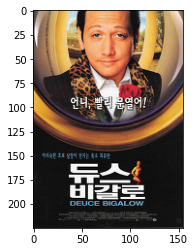

['코미디']



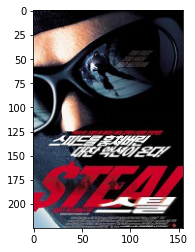

['범죄', '액션']



In [4]:
for i in range(5):
    sample_img_dir = image_dir+os.listdir(image_dir)[i]
    sample_genre = genres_dict[int(os.listdir(image_dir)[i].split('.')[0])]
    _ = plt.imread(sample_img_dir)
    plt.imshow(_)
    plt.show()
    print(sample_genre)
    print()

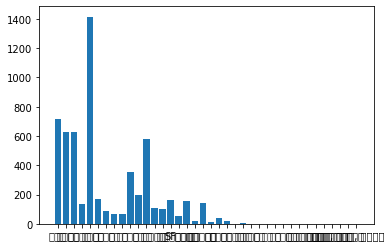

In [5]:
## 국가 데이터가 있음

n_genres = {item:0 for i in genres_dict.values() for item in i}
for key in genres_dict:
    values = genres_dict[key]
    for item in values:
        n_genres[item]+=1
plt.bar(range(len(n_genres)), list(n_genres.values()), align='center')
plt.xticks(range(len(n_genres)), list(n_genres.keys()))
plt.show()

In [6]:
list({item for i in genres_dict.values() for item in i})

['무협',
 '서부',
 '미국',
 '프랑스, 스위스, 이탈리아',
 '드라마',
 '프랑스',
 '대만',
 '시대극',
 '공포',
 '어드벤처',
 '브라질',
 '영국',
 '멜로',
 '로맨스',
 '스웨덴',
 '애니메이션',
 '한국',
 '오스트레일리아',
 '코미디',
 '러시아',
 '스페인',
 '성인',
 '전쟁',
 '네덜란드',
 '노르웨이',
 '미스터리',
 '범죄',
 '다큐멘터리',
 '캐나다',
 '헝가리',
 '액션',
 '뮤지컬',
 '판타지',
 '스릴러',
 'SF',
 '독일',
 '가족',
 '핀란드']

# 데이터 준비

In [7]:
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

import torchvision
from torchvision import transforms,datasets

In [8]:
class CustomDataset(Dataset):
    def __init__(self,transform):
        self.imgs_dir = 'poster/daum/'
        self.transform = transform
        self.image_list = os.listdir(self.imgs_dir)
        self.label_dir = 'poster/daum.txt'
        
        self.labels = pickle.load(open(self.label_dir, 'rb'))
        self.label_list = list({item for i in self.labels.values() for item in i})
        self.num_label = len(self.label_list)
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self,idx):
        img_dir = self.image_list[idx]
        image = Image.open(os.path.join(self.imgs_dir, img_dir))
        image.convert('RGB')
        x = self.transform(image)
        if x.size(0)==4:x=x[:-1,:,:]
        if x.size(0)==1:x=x.expand(3,-1,-1)
        labels = self.labels[int(img_dir.split('.')[0])]
        labels_encoding = [self.label_list.index(i) for i in labels]
        y = torch.zeros(self.num_label)
        y[labels_encoding]=1
        return x,y

In [9]:
mytransform=transforms.Compose([transforms.Resize((128,128)),
                                transforms.RandomRotation(45),
                                transforms.RandomAffine(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor()])

In [10]:
dset = CustomDataset(mytransform)
dset[0][0].size(),dset[0][1]

(torch.Size([3, 128, 128]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [11]:
ratio = [int(len(dset)*0.8),len(dset)-int(len(dset)*0.8)]
trainset, valset = torch.utils.data.random_split(dset,ratio)

# 모델 구축

multi label binary classification

In [12]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

### resnet 사용

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score
import numpy as np

In [14]:
res_model = torchvision.models.resnet101(pretrained=True) # load the pretrained model
num_features = res_model.fc.in_features # get the no of on_features in last Linear unit
for param in res_model.parameters():
    param.requires_grad_(False)
top_head = create_head(num_features , 38)
res_model.fc = top_head # replace the fully connected layer

In [15]:
def select_optimizer(model, args):
    lr = args['lr']
    betas = args['betas']
    weight_decay = args['weight_decay']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas , weight_decay=weight_decay)
    return optimizer

def select_scheduler(optimizer, config):
    T_max = config['T_max']
    verbose = config['verbose']

    scheduler = CosineAnnealingLR(optimizer,T_max=T_max,verbose=verbose)
    return scheduler

def f1_score_(pred, target, threshold=0.2):
    pred = np.array(pred.cpu() > threshold, dtype=float)
    return f1_score(target.cpu(), pred, average='micro')

In [16]:
batch_size = 256
optim_args = {'lr':0.05,'betas':(0.9,0.999),'weight_decay':0.001}
sche_args = {'T_max':100,'verbose':True}

In [17]:
train_dataloader = DataLoader(trainset,batch_size=batch_size,
                        shuffle=True,num_workers=4,
                        drop_last=True,pin_memory=True)

val_dataloader = DataLoader(valset,batch_size=batch_size,num_workers=4)

In [18]:
res_model.cuda()
optimizer = select_optimizer(res_model,optim_args)
scheduler = select_scheduler(optimizer, sche_args)
criterion = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 5.0000e-02.


In [19]:
plot_list = {'train':[],'val':[],'accuracy':[]}

for epoch in range(sche_args['T_max']):
    res_model.train()
    train_losses = []
    train_measure = 0
    train_cnt = 0
    for idx,data in enumerate(train_dataloader):
        x,y = data
        x,y = x.cuda(),y.cuda()
        optimizer.zero_grad()
        y_pred = res_model(x)

        loss = criterion(y_pred,y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.detach())
        train_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25) * batch_size
        train_cnt += batch_size
    
    res_model.eval()
    val_losses = []
    val_measure = 0
    val_cnt = 0
    for idx,data in enumerate(val_dataloader):
        x,y = data
        x,y = x.cuda(),y.cuda()
        y_pred = res_model(x)
        loss = criterion(y_pred,y)
        val_losses.append(loss.detach())
        val_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25)
        val_cnt += 1
    scheduler.step()
        
    print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
    print(f"{epoch+1} epoch train f1 = {train_measure/train_cnt}")
    
    print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
    print(f"{epoch+1} epoch val f1 = {val_measure/val_cnt}")
    print('--------------------------------------------------')
    plot_list['train'].append(sum(train_losses)/len(train_losses))
    plot_list['val'].append(sum(val_losses)/len(val_losses))

Adjusting learning rate of group 0 to 4.9988e-02.
1 epoch train loss = 0.7874862551689148
1 epoch train f1 = 0.1458873764011896
1 epoch val loss = 0.5438967943191528
1 epoch val f1 = 0.24923389710648833
--------------------------------------------------
Adjusting learning rate of group 0 to 4.9951e-02.
2 epoch train loss = 0.21426813304424286
2 epoch train f1 = 0.27649939305548726
2 epoch val loss = 0.1707608699798584
2 epoch val f1 = 0.31432697398111376
--------------------------------------------------
Adjusting learning rate of group 0 to 4.9889e-02.
3 epoch train loss = 0.1558178812265396
3 epoch train f1 = 0.28830989024092657
3 epoch val loss = 0.13553467392921448
3 epoch val f1 = 0.3169609351305122
--------------------------------------------------
Adjusting learning rate of group 0 to 4.9803e-02.
4 epoch train loss = 0.1348450779914856
4 epoch train f1 = 0.31936737203655163
4 epoch val loss = 0.13368350267410278
4 epoch val f1 = 0.3068357107968566
-------------------------------

Adjusting learning rate of group 0 to 3.7726e-02.
33 epoch train loss = 0.13031214475631714
33 epoch train f1 = 0.30800995822194693
33 epoch val loss = 0.13218429684638977
33 epoch val f1 = 0.32046791306395495
--------------------------------------------------
Adjusting learning rate of group 0 to 3.7044e-02.
34 epoch train loss = 0.1290493607521057
34 epoch train f1 = 0.33746362050609124
34 epoch val loss = 0.12923090159893036
34 epoch val f1 = 0.364345516058956
--------------------------------------------------
Adjusting learning rate of group 0 to 3.6350e-02.
35 epoch train loss = 0.12904229760169983
35 epoch train f1 = 0.33225875102972496
35 epoch val loss = 0.1282261610031128
35 epoch val f1 = 0.3569912238775707
--------------------------------------------------
Adjusting learning rate of group 0 to 3.5644e-02.
36 epoch train loss = 0.1295650601387024
36 epoch train f1 = 0.3356808768183618
36 epoch val loss = 0.12974189221858978
36 epoch val f1 = 0.3702068508254288
---------------

Adjusting learning rate of group 0 to 1.3650e-02.
65 epoch train loss = 0.12720684707164764
65 epoch train f1 = 0.34365643545893837
65 epoch val loss = 0.1299096643924713
65 epoch val f1 = 0.363118472560445
--------------------------------------------------
Adjusting learning rate of group 0 to 1.2956e-02.
66 epoch train loss = 0.1276504546403885
66 epoch train f1 = 0.3384090482786956
66 epoch val loss = 0.13151279091835022
66 epoch val f1 = 0.30856456477764554
--------------------------------------------------
Adjusting learning rate of group 0 to 1.2274e-02.
67 epoch train loss = 0.12757757306098938
67 epoch train f1 = 0.33825847831633565
67 epoch val loss = 0.13018423318862915
67 epoch val f1 = 0.34788699912425947
--------------------------------------------------
Adjusting learning rate of group 0 to 1.1604e-02.
68 epoch train loss = 0.12733611464500427
68 epoch train f1 = 0.3467518080775203
68 epoch val loss = 0.12957042455673218
68 epoch val f1 = 0.3827359957522661
--------------

Adjusting learning rate of group 0 to 1.1095e-04.
97 epoch train loss = 0.12408974021673203
97 epoch train f1 = 0.3796147572470586
97 epoch val loss = 0.12454800307750702
97 epoch val f1 = 0.3946964259276884
--------------------------------------------------
Adjusting learning rate of group 0 to 4.9332e-05.
98 epoch train loss = 0.12349898368120193
98 epoch train f1 = 0.3767333821346972
98 epoch val loss = 0.12431075423955917
98 epoch val f1 = 0.3802411718345646
--------------------------------------------------
Adjusting learning rate of group 0 to 1.2336e-05.
99 epoch train loss = 0.1235705241560936
99 epoch train f1 = 0.38127317826991153
99 epoch val loss = 0.12441246211528778
99 epoch val f1 = 0.39398496240601505
--------------------------------------------------
Adjusting learning rate of group 0 to 0.0000e+00.
100 epoch train loss = 0.12310496717691422
100 epoch train f1 = 0.38454177247742327
100 epoch val loss = 0.1243191808462143
100 epoch val f1 = 0.3916480281439699
----------

### EfficientNet 사용

In [20]:
from efficientnet_pytorch import EfficientNet

In [21]:
eff_model = EfficientNet.from_pretrained('efficientnet-b6') # load the pretrained model
num_features = eff_model._fc.in_features # get the no of on_features in last Linear unit
for param in eff_model.parameters():
    param.requires_grad_(False)
top_head = create_head(num_features , 38)
eff_model._fc = top_head # replace the fully connected layer

Loaded pretrained weights for efficientnet-b6


In [22]:
batch_size = 64
optim_args = {'lr':0.1,'betas':(0.9,0.999),'weight_decay':0.001}
sche_args = {'T_max':100,'verbose':True}

In [23]:
train_dataloader = DataLoader(trainset,batch_size=batch_size,
                        shuffle=True,num_workers=4,
                        drop_last=True,pin_memory=True)

val_dataloader = DataLoader(valset,batch_size=batch_size,num_workers=4)

In [24]:
eff_model.cuda()
optimizer = select_optimizer(eff_model,optim_args)
scheduler = select_scheduler(optimizer, sche_args)
criterion = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 1.0000e-01.


In [25]:
plot_list = {'train':[],'val':[],'accuracy':[]}

for epoch in range(sche_args['T_max']):
    eff_model.train()
    train_losses = []
    train_measure = 0
    train_cnt = 0
    for idx,data in enumerate(train_dataloader):
        x,y = data
        x,y = x.cuda(),y.cuda()
        optimizer.zero_grad()
        y_pred = eff_model(x)

        loss = criterion(y_pred,y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.detach())
        train_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25) * batch_size
        train_cnt += batch_size
    
    eff_model.eval()
    val_losses = []
    val_measure = 0
    val_cnt = 0
    for idx,data in enumerate(val_dataloader):
        x,y = data
        x,y = x.cuda(),y.cuda()
        y_pred = eff_model(x)
        loss = criterion(y_pred,y)
        val_losses.append(loss.detach())
        val_measure += f1_score_(torch.sigmoid(y_pred), y, threshold=0.25)
        val_cnt += 1
    scheduler.step()
        
    print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
    print(f"{epoch+1} epoch train f1 = {train_measure/train_cnt}")
    
    print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
    print(f"{epoch+1} epoch val f1 = {val_measure/val_cnt}")
    print('--------------------------------------------------')
    plot_list['train'].append(sum(train_losses)/len(train_losses))
    plot_list['val'].append(sum(val_losses)/len(val_losses))

Adjusting learning rate of group 0 to 9.9975e-02.
1 epoch train loss = 0.42444682121276855
1 epoch train f1 = 0.2099094657509716
1 epoch val loss = 0.1610744744539261
1 epoch val f1 = 0.343546548740758
--------------------------------------------------
Adjusting learning rate of group 0 to 9.9901e-02.
2 epoch train loss = 0.1449040174484253
2 epoch train f1 = 0.2623261634012015
2 epoch val loss = 0.13082903623580933
2 epoch val f1 = 0.3436556137348598
--------------------------------------------------
Adjusting learning rate of group 0 to 9.9778e-02.
3 epoch train loss = 0.13564571738243103
3 epoch train f1 = 0.2963211751576107
3 epoch val loss = 0.13194382190704346
3 epoch val f1 = 0.32540084388407925
--------------------------------------------------
Adjusting learning rate of group 0 to 9.9606e-02.
4 epoch train loss = 0.13666121661663055
4 epoch train f1 = 0.3023713662130321
4 epoch val loss = 0.13476192951202393
4 epoch val f1 = 0.3260548871441599
---------------------------------

Adjusting learning rate of group 0 to 7.5452e-02.
33 epoch train loss = 0.14087335765361786
33 epoch train f1 = 0.2850189953840258
33 epoch val loss = 0.13484984636306763
33 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 7.4088e-02.
34 epoch train loss = 0.1394798755645752
34 epoch train f1 = 0.28092211446267895
34 epoch val loss = 0.13587923347949982
34 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 7.2700e-02.
35 epoch train loss = 0.13818348944187164
35 epoch train f1 = 0.285807469169804
35 epoch val loss = 0.13716331124305725
35 epoch val f1 = 0.3565403438701655
--------------------------------------------------
Adjusting learning rate of group 0 to 7.1289e-02.
36 epoch train loss = 0.1397327184677124
36 epoch train f1 = 0.29596886576573983
36 epoch val loss = 0.13549762964248657
36 epoch val f1 = 0.3268983807412767
----------------

Adjusting learning rate of group 0 to 2.7300e-02.
65 epoch train loss = 0.13529403507709503
65 epoch train f1 = 0.291782172243255
65 epoch val loss = 0.1327812671661377
65 epoch val f1 = 0.32417490386924736
--------------------------------------------------
Adjusting learning rate of group 0 to 2.5912e-02.
66 epoch train loss = 0.13511577248573303
66 epoch train f1 = 0.2988469791183387
66 epoch val loss = 0.12870627641677856
66 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 2.4548e-02.
67 epoch train loss = 0.13516183197498322
67 epoch train f1 = 0.3037066779163875
67 epoch val loss = 0.13074560463428497
67 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 2.3209e-02.
68 epoch train loss = 0.13497255742549896
68 epoch train f1 = 0.29579216534585934
68 epoch val loss = 0.13487763702869415
68 epoch val f1 = 0.3436558751717524
---------------

Adjusting learning rate of group 0 to 2.2190e-04.
97 epoch train loss = 0.13111945986747742
97 epoch train f1 = 0.30070384693021424
97 epoch val loss = 0.128348708152771
97 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 9.8664e-05.
98 epoch train loss = 0.1314147561788559
98 epoch train f1 = 0.2965457671875854
98 epoch val loss = 0.12837401032447815
98 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 2.4672e-05.
99 epoch train loss = 0.13115869462490082
99 epoch train f1 = 0.3000551536592697
99 epoch val loss = 0.12834757566452026
99 epoch val f1 = 0.3260548871441599
--------------------------------------------------
Adjusting learning rate of group 0 to 0.0000e+00.
100 epoch train loss = 0.1312854140996933
100 epoch train f1 = 0.29813169560746783
100 epoch val loss = 0.12834885716438293
100 epoch val f1 = 0.3260548871441599
-------------

# 임베딩 벡터 추출

In [51]:
forward_model=nn.Sequential(*list(res_model.children())[:-1]).cpu()
embbeding_layer = nn.Sequential(*list(res_model.children())[-1][:-2]).cpu()

In [113]:
label_list = list({item for i in genres_dict.values() for item in i})

In [120]:
img2vec_result = {}
for i,d in enumerate(dset):
    x,y = d
    genres = [label_list[i] for i in (y == 1).nonzero().view(-1)]
    vec = embbeding_layer(forward_model(x.unsqueeze(0)).view(1,2048))
    img2vec_result[i] = vec[0].tolist(),genres

# Kmeans Clustering

장르 중 갯수가 상위 10위안에 드는 장르와 10개 군집으로 했을때 비교

In [173]:
from collections import Counter 
k = Counter(n_genres) 
high = k.most_common(10)
high

[('드라마', 1415),
 ('코미디', 713),
 ('로맨스', 624),
 ('멜로', 624),
 ('액션', 578),
 ('스릴러', 353),
 ('범죄', 200),
 ('공포', 170),
 ('SF', 160),
 ('어드벤처', 158)]

In [174]:
from sklearn.cluster import KMeans
import numpy as np

In [175]:
X = np.array([img2vec_result[i][0] for i in img2vec_result])
y = [img2vec_result[i][1] for i in img2vec_result]

In [176]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [178]:
result = {i:{} for i in range(10)}
for c,genres in zip(kmeans.labels_,y):
    for genre in genres:
        try:
            result[c][genre]+=1
        except:
            result[c][genre]=1

In [179]:
for key,value in result.items():
    print(key, Counter(value).most_common(5))

0 [('드라마', 203), ('멜로', 85), ('로맨스', 85), ('코미디', 82), ('액션', 44)]
1 [('코미디', 71), ('액션', 68), ('드라마', 48), ('스릴러', 36), ('SF', 33)]
2 [('액션', 94), ('스릴러', 81), ('공포', 57), ('드라마', 53), ('SF', 47)]
3 [('드라마', 237), ('멜로', 115), ('로맨스', 115), ('액션', 47), ('코미디', 38)]
4 [('코미디', 129), ('드라마', 104), ('멜로', 66), ('로맨스', 66), ('애니메이션', 16)]
5 [('드라마', 165), ('멜로', 113), ('로맨스', 113), ('코미디', 73), ('액션', 23)]
6 [('드라마', 164), ('액션', 122), ('스릴러', 92), ('멜로', 58), ('로맨스', 58)]
7 [('드라마', 248), ('액션', 109), ('멜로', 91), ('로맨스', 91), ('스릴러', 49)]
8 [('코미디', 102), ('드라마', 43), ('애니메이션', 42), ('멜로', 26), ('로맨스', 26)]
9 [('드라마', 149), ('코미디', 114), ('액션', 51), ('멜로', 49), ('로맨스', 49)]
